# XGBoost (Paper 2 Inspired) for House Price Prediction

This notebook implements an XGBoost Regressor for the **House Prices – Advanced Regression Techniques** Kaggle dataset. The hyperparameters are tuned using randomized search, inspired by a paper that applies Bayesian optimization to XGBoost for house price prediction.

Assumption: `train.csv` is in the same folder as this notebook.

If XGBoost is not installed, you may need to run `pip install xgboost` in your environment.

In [3]:
%pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 75.6 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.3
    Uninstalling numpy-2.3.3:
      Successfully uninstalled numpy-2.3.3━━━━━━ 0/2 [numpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
streamlit 1.30.0 requires importlib-metadata<8,>=1.4, but you have importlib-metadata 8.5.0 which is incompatible.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
streamlit 1.30.0 requires pillow<11,>=

## Load and Inspect the Data

In [4]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print(df['SalePrice'].describe())
df.isna().sum().sort_values(ascending=False).head(20)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

## Basic Cleaning and Feature Definition

In [6]:
df = df.drop(columns=['Id'])

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
print('Numeric features:', len(numeric_features))
print('Categorical features:', len(categorical_features))

Numeric features: 36
Categorical features: 43


## Train/Validation Split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_val.shape

((1168, 79), (292, 79))

## Preprocessing and XGBoost Model

In [8]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

xgb_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb)
    ]
)

param_dist = {
    'regressor__n_estimators': [200, 400, 600],
    'regressor__max_depth': [3, 4, 5, 6],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
random_search

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlr...
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None, ...))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'regressor__colsample_bytree': [0.6,
                                                                        0.8,
                                                                        1.0],
                                        'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1],
                                        'regressor__max_depth': [3, 4, 5, 6],
                                        'regressor__n_estimators': [200, 400,
                                                                    600],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

## Train XGBoost with Randomized Search

In [9]:
random_search.fit(X_train, y_train)
print('Best parameters:', random_search.best_params_)

Best parameters: {'regressor__subsample': 0.6, 'regressor__n_estimators': 600, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.8}


## Evaluation: MSE and MAE

In [10]:
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f'XGBoost (Paper 2) MSE: {mse:.2f}')
print(f'XGBoost (Paper 2) MAE: {mae:.2f}')

XGBoost (Paper 2) MSE: 649695978.71
XGBoost (Paper 2) MAE: 15764.20


## Feature Importances (Top 20)

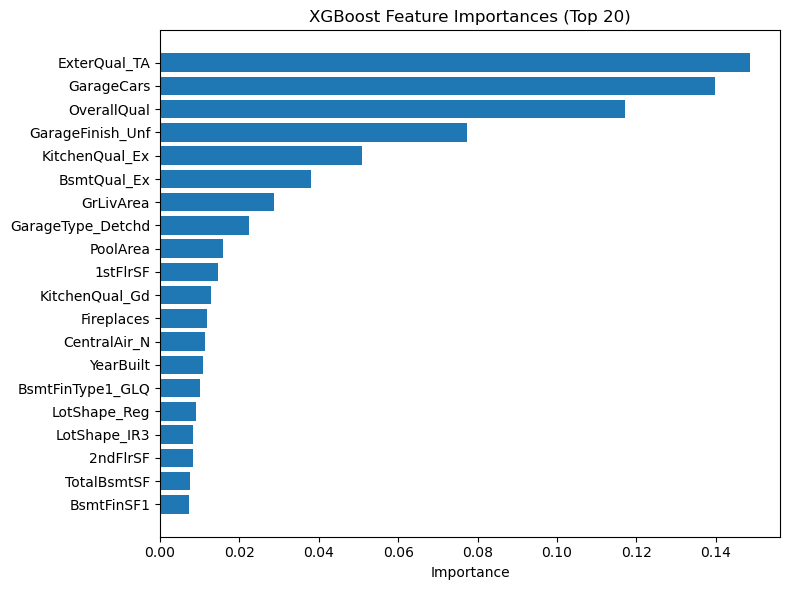

In [11]:
pre = best_xgb_model.named_steps['preprocessor']
xgb_reg = best_xgb_model.named_steps['regressor']

onehot = pre.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), all_feature_names[indices][::-1])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances (Top 20)')
plt.tight_layout()
plt.show()